In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d

In [2]:
TIME_STEP = 1/1000

In [3]:
class Plant:
    
    def __init__(self, noise_scale=0, noise_decay=0, noise_momentum=0.5):
        self.__x = 0
        self.__y = 0
        self.__z = 0
        self.__vx = 0
        self.__vy = 0
        self.__vz = 0
        self.__noise_scale = noise_scale
        self.__noise_decay = noise_decay
        self.__noise_momentum = noise_momentum
        self.noise = np.zeros(3)
    
    def step(self, ax, ay, az):
        noise = np.random.randn(3) * self.__noise_scale
        self.noise = \
            self.__noise_momentum*self.noise + \
            (1-self.__noise_momentum)*noise
        self.noise *= 1-self.__noise_decay
        ax += self.noise[0]
        ay += self.noise[1]
        az += self.noise[2]
        self.__x += self.__vx*TIME_STEP + 0.5*ax*TIME_STEP**2
        self.__y += self.__vy*TIME_STEP + 0.5*ay*TIME_STEP**2
        self.__z += self.__vz*TIME_STEP + 0.5*az*TIME_STEP**2
        self.__vx += ax*TIME_STEP
        self.__vy += ay*TIME_STEP
        self.__vz += az*TIME_STEP
        return self.__x, self.__y, self.__z

In [4]:
class PIDController:
    
    def __init__(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.disable_integral = False
        self.ierr = 0
        self.__prev_err = 0
    
    def step(self, measured, desired):
        err = desired - measured
        self.ierr = 0 if self.disable_integral else self.ierr + err*TIME_STEP
        derr = (err-self.__prev_err)/TIME_STEP
        self.__prev_err = err
        return self.Kp*err + self.Ki*self.ierr + self.Kd*derr

In [5]:
class Target:
    
    def __init__(self, scale=1, momentum=0.5):
        self.__plant = Plant(noise_scale=0)
        self.__scale = scale
        self.__momentum = momentum
        self.__a = np.zeros((3,))
    
    def step(self):
        self.__a = self.__a*self.__momentum + \
            (1-self.__momentum)*np.random.randn(3)
        return self.__plant.step(*self.__a*self.__scale)

final noise -0.14014550255953187 3.028997135329255 -2.545851807347377
final ierr -0.012524453041834154 -0.02052401284276355 -0.018293973520873797
final err -0.09154772951696444 -0.18553559362331384 -0.10870872341922677


<IPython.core.display.Javascript object>


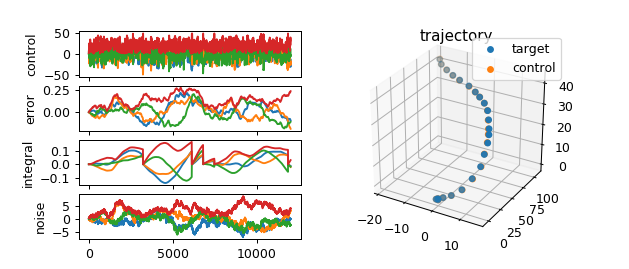

In [6]:
Kp,Ki,Kd = 10,100,35
control_max = 50
plant = Plant(noise_scale=100, noise_decay=0, noise_momentum=0.999)
target = Target(scale=100, momentum=0.5)
pid_x, pid_y, pid_z = [PIDController(Kp,Ki,Kd) for _ in range(3)]
x,y,z = plant.step(0,0,0)
T, Y, C, E, I, N = [[] for _ in range(6)]
for t in range(12000):
    tx,ty,tz = target.step()
    cx = pid_x.step(x,tx)
    cy = pid_y.step(y,ty)
    cz = pid_z.step(z,tz)
    clen = np.linalg.norm((cx,cy,cz))
    pid_x.disable_integral = \
    pid_y.disable_integral = \
    pid_z.disable_integral = clen > control_max
    if clen > control_max:
        cx,cy,cz = np.array([cx,cy,cz])/clen*control_max
    x,y,z = plant.step(cx,cy,cz)
    T.append((tx,ty,tz))
    Y.append((x,y,z))
    C.append((cx,cy,cz,np.linalg.norm((cx,cy,cz))))
    E.append((tx-x,ty-y,tz-z,np.linalg.norm((tx-x,ty-y,tz-z))))
    I.append((pid_x.ierr,pid_y.ierr,pid_z.ierr,np.linalg.norm((pid_x.ierr,pid_y.ierr,pid_z.ierr))))
    N.append((*plant.noise,np.linalg.norm(plant.noise)))
print('final noise', *plant.noise)
print('final ierr', pid_x.ierr, pid_y.ierr, pid_z.ierr)
print('final err', tx-x, ty-y, tz-z)
plt.figure(figsize=(7,3))
ax = plt.subplot(122, projection='3d'); plt.title('trajectory')
ax.scatter(*np.moveaxis(T[::500],0,-1)); ax.scatter(*np.moveaxis(Y[::500],0,-1))
plt.legend(['target', 'control'])
plt.subplot(421); plt.ylabel('control'); plt.plot(C)
plt.subplot(423); plt.ylabel('error'); plt.plot(E)
plt.subplot(425); plt.ylabel('integral'); plt.plot(I)
plt.subplot(427); plt.ylabel('noise'); plt.plot(N)
plt.show()

In [8]:
import keras
import keras.backend as K

Using TensorFlow backend.


In [42]:
class PIDCell(keras.layers.Layer):
    
    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = (units, units)
        super(PIDCell, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.built = True
    
    def call(self, inputs, states):
        dt, err, Kp, Ki, Kd, reset_integral = \
            inputs[:,0:1],inputs[:,1:self.units+1], \
            inputs[:,self.units+1:self.units+2],inputs[:,self.units+2:self.units+3], \
            inputs[:,self.units+3:self.units+4],inputs[:,self.units+4:self.units+5]
        perr, ierr = states
        ierr = (1-K.sigmoid(reset_integral))*(ierr+err*dt)
        derr = (err-perr)/dt
        perr = err
        return K.relu(Kp)*err + K.relu(Ki)*ierr + K.relu(Kd)*derr, [perr, ierr]

In [57]:
X_input_dt = keras.layers.Input((None, 1), batch_shape=(1,1,1))
X_input_err = keras.layers.Input((None, 3), batch_shape=(1,1,3))
X = keras.layers.LSTM(32, stateful=True, return_sequences=True, activation='relu', kernel_initializer='he_normal')(X_input_err)
X_Kp = keras.layers.LSTM(1, stateful=True, return_sequences=True, activation=None)(X)
X_Ki = keras.layers.LSTM(1, stateful=True, return_sequences=True, activation=None)(X)
X_Kd = keras.layers.LSTM(1, stateful=True, return_sequences=True, activation=None)(X)
X_reset_integral = keras.layers.LSTM(1, stateful=True, return_sequences=True, activation=None)(X)
X = keras.layers.Concatenate()([X_input_dt,X_input_err,X_Kp,X_Ki,X_Kd,X_reset_integral])
X_pid = keras.layers.RNN(PIDCell(3), stateful=True, return_sequences=True)(X)
X = keras.layers.Concatenate()([X_input_err, X_pid])
X = keras.layers.LSTM(32, stateful=True, return_sequences=True, activation='relu', kernel_initializer='he_normal')(X)
X = keras.layers.LSTM(3, stateful=True, return_sequences=True, activation=None)(X)
M = keras.Model([X_input_dt,X_input_err], [X,X_pid])
M.compile('adam', 'mse', loss_weights=[1,0])
M.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           (1, 1, 3)            0                                            
__________________________________________________________________________________________________
lstm_94 (LSTM)                  (1, 1, 32)           4608        input_40[0][0]                   
__________________________________________________________________________________________________
input_39 (InputLayer)           (1, 1, 1)            0                                            
__________________________________________________________________________________________________
lstm_95 (LSTM)                  (1, 1, 1)            136         lstm_94[0][0]                    
__________________________________________________________________________________________________
lstm_96 (L

final noise 0.9579659072706439 -2.290372280464477 0.15647140848415939
final ierr -0.012524453041834154 -0.02052401284276355 -0.018293973520873797
final err 1.0888101554200305 -1.8923268070808013 1.5049592781506456


<IPython.core.display.Javascript object>


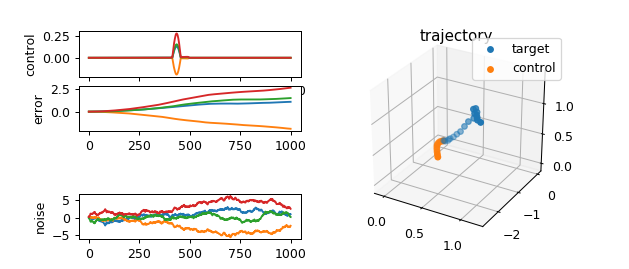

In [58]:
control_max = 50
plant = Plant(noise_scale=100, noise_decay=0, noise_momentum=0.999)
target = Target(scale=100, momentum=0.5)
x,y,z = plant.step(0,0,0)
T, Y, C, E, N = [[] for _ in range(5)]
M.reset_states()
for t in range(1000):
    tx,ty,tz = target.step()
    cx,cy,cz = M.predict([
        np.array([[[TIME_STEP]]]),
        np.array([[[tx-x,ty-y,tz-z]]])])[1][0,0]
    clen = np.linalg.norm((cx,cy,cz))
    pid_x.disable_integral = \
    pid_y.disable_integral = \
    pid_z.disable_integral = clen > control_max
    if clen > control_max:
        cx,cy,cz = np.array([cx,cy,cz])/clen*control_max
    x,y,z = plant.step(cx,cy,cz)
    T.append((tx,ty,tz))
    Y.append((x,y,z))
    C.append((cx,cy,cz,np.linalg.norm((cx,cy,cz))))
    E.append((tx-x,ty-y,tz-z,np.linalg.norm((tx-x,ty-y,tz-z))))
    N.append((*plant.noise,np.linalg.norm(plant.noise)))
print('final noise', *plant.noise)
print('final ierr', pid_x.ierr, pid_y.ierr, pid_z.ierr)
print('final err', tx-x, ty-y, tz-z)
plt.figure(figsize=(7,3))
ax = plt.subplot(122, projection='3d'); plt.title('trajectory')
ax.scatter(*np.moveaxis(T[::50],0,-1)); ax.scatter(*np.moveaxis(Y[::50],0,-1))
plt.legend(['target', 'control'])
plt.subplot(421); plt.ylabel('control'); plt.plot(C)
plt.subplot(423); plt.ylabel('error'); plt.plot(E)
#plt.subplot(425); plt.ylabel('integral'); plt.plot(I)
plt.subplot(427); plt.ylabel('noise'); plt.plot(N)
plt.show()